In [6]:
import torch
from torch.utils.data import DataLoader

from gpt.data import TextDataset
from gpt.models.mlp import MLP
from gpt.models.transformer import Transformer
from gpt.run_experiments import fit, eval, get_experiments, REPO_DIR
REPO_DIR
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
max_steps=100
batch_size=64
block_size=256
max_epochs=1
learning_rate=3e-4
device = torch.device('cpu')


In [8]:
ds_train = TextDataset(f'{REPO_DIR}/data/shakespeare.txt', 'train', block_size=block_size)
ds_val = TextDataset(f'{REPO_DIR}/data/shakespeare.txt', 'val', block_size=block_size)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)

vocab_size = len(ds_train.vocab)
exp = get_experiments(block_size, vocab_size)['mlp']
model = exp.model

In [14]:
train_losses, val_losses = fit(model, device, dl_train, dl_val, max_epochs=max_epochs, learning_rate=learning_rate)


1:20|s=20 loss: 4.2767791748046875 val_loss: 4.261282920837402 lr: 0.0003
1:40|s=40 loss: 4.290515899658203 val_loss: 4.248204231262207 lr: 0.0003
1:60|s=60 loss: 4.153140544891357 val_loss: 4.235097408294678 lr: 0.0003
1:80|s=80 loss: 4.1900105476379395 val_loss: 4.224499702453613 lr: 0.0003
1:100|s=100 loss: 4.174770832061768 val_loss: 4.21420955657959 lr: 0.0003
1:120|s=120 loss: 4.238462448120117 val_loss: 4.2025299072265625 lr: 0.0003
1:140|s=140 loss: 4.040025234222412 val_loss: 4.192957401275635 lr: 0.0003
1:160|s=160 loss: 4.183646202087402 val_loss: 4.182941913604736 lr: 0.0003
1:180|s=180 loss: 4.223228931427002 val_loss: 4.173860549926758 lr: 0.0003
1:200|s=200 loss: 4.297732830047607 val_loss: 4.163761615753174 lr: 0.0003
1:220|s=220 loss: 4.141749382019043 val_loss: 4.154739856719971 lr: 0.0003
1:240|s=240 loss: 4.076364040374756 val_loss: 4.146159648895264 lr: 0.0003
1:260|s=260 loss: 4.159627914428711 val_loss: 4.13691520690918 lr: 0.0003
1:280|s=280 loss: 4.183528423309

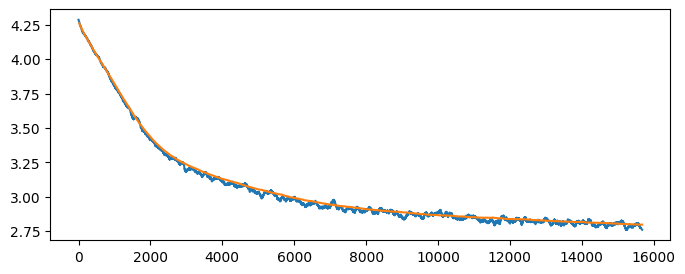

In [19]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
train_losses_smoothed = savgol_filter(train_losses, 100, 1)
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(train_losses_smoothed)
ax.plot(val_losses.keys(),val_losses.values())


In [23]:
x.shape

torch.Size([1, 256])

In [24]:
x.shape

torch.Size([1, 256])

In [21]:
x = ds_val[0][0].unsqueeze(0)
y_pred = model.predict(x, 1000)
print(''.join(ds_train.decode(y_pred[0])))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 3])